In [2]:
import os
import glob

import pandas as pd
import numpy as np
import datetime

from skimage import io
from datetime import timedelta
from datetime import datetime
from scipy.stats import pearsonr

from netCDF4 import Dataset

# Imports for plotting
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter 
from matplotlib.ticker import MultipleLocator, FormatStrFormatter 
from matplotlib.dates import MonthLocator
import matplotlib.patheffects as PathEffects

### LOAD AND SET UP DATA 

In [9]:
#base path
base_path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/'

#data paths
depth_3m_path = 'depths_3m/equal_extent_data_downsize/{}/*.tif'
# mask files
mask_3m_file = '/home/meganmason/Documents/projects/thesis/maps/map_layers/basin_ops/tuolumne/topo/basin_setup/topo.nc' #this is 3m, only TB, downloaded 8-8 with Micah
mask_50m_file = '/home/meganmason/Documents/projects/thesis/maps/map_layers/basin_ops/tuolumne/topo/topo_50m.nc' #first topo.nc downloaded, renamed to _50m.nc
# dem 
dem_3m_file = 'TB20140827_snow_free_dtm_vf_3p0m.tif'

In [10]:
# years and flight dates (3m)
years = list(range(2013,2019)) # 2013-2018

flist = []
for year in sorted(years):
    flist_yr = glob.glob(base_path + depth_3m_path.format(year))
    flist.extend(flist_yr) #.append adds list to lists (ie multiple lists), .extend tacks on to og list (ie one list) 

# dates=[]
# for f in flist:
# #     print(f)
#     dt_str = f.split("/")[-1] #splits on / and saves the last one
#     dt_str = "".join([c for c in dt_str if c.isnumeric()]) #grabs numeric values
#     dt = pd.to_datetime(dt_str[:8]) #convert to datetime, grabs digits for dates only
# #     print('flight date:',dt.date())
#     dates.append(dt.date()) #.date to exclude time (00:00:00)
    
# dates = pd.to_datetime(dates) #could revisit (seems like I put it in datetime 2x, w/o here it's a class 'list')
# # print(type(date))
# # print(date)

    
# ~~~~~~~~~~~~~~ASK MICAH FOR HELP - LIST COMPREHENSION  ~~~~~~~~~~~~  
# flist = ([glob.glob(flist_yr).extend for year in years])
# print(flist)
# flist = (glob.glob(base_path + depth_3m_path.format(year)) for year in years)
# print(flist)

In [5]:
# function for DATETIME - kinda works?
def flight_date(f):
#     print(f)
    dt_str = f.split("/")[-1] #splits on / and saves the last one
    dt_str = "".join([c for c in dt_str if c.isnumeric()]) #grabs numeric values
    dt = pd.to_datetime(dt_str[:8]) #convert to datetime, grabs digits for dates only
#     print('flight date:',dt.date())
#         dates.append(dt.date()) #.date to exclude time (00:00:00)
    
    return dt.date() #pd.to_datetime(dt.date)

datelist = [flight_date(f) for f in sorted(flist)] 
#print(datelist[0].strftime('%Y-%m-%d'))

#### 50m below

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~
#test with 50m lidar .tifs (use this until you get 3 meter mask - gdalme, veg data, Makefile.....)
#~~~~~~~~~~~~~~~~~~~~~~~

# path_50m_tifs = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_50m/all/tmp/*.tif'
# flist = sorted(glob.glob(path_50m_tifs))


# path_50m_tifs = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_50m/{}/*.tif'
# years = list(range(2013,2019)) # 2013-2018
# flist = []
# for year in sorted(years):
#     flist_yr = glob.glob(path_50m_tifs.format(year))
#     flist.extend(flist_yr) #.append adds list to lists (ie multiple lists), .extend tacks on to og list (ie one list) 
# # flist


odict_keys(['y', 'x', 'veg_height', 'veg_tau', 'veg_k', 'veg_type', 'dem', 'mask', 'projection'])
mask shape: (17002, 17569) 
mask value to use: 1 
# of pixels in mask: 131291738


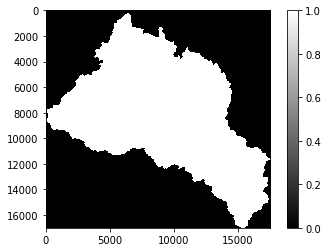

In [6]:
#mask checking (3m)
ds = Dataset(mask_3m_file) #using 'from netCDF4 import Dataset'
print(ds.variables.keys())
mask = ds.variables['mask'] #grab tum mask variable, use ds.variables.keys() to list all possible variables
print('mask shape:', mask.shape, 
      '\nmask value to use:', np.max(mask), 
      '\n# of pixels in mask:', np.sum(mask))
plt.imshow(mask, cmap='gray')
plt.colorbar()

### ANALYSIS..testing

In [11]:
#~~~~~~ FUNCTIONS ~~~~~~~~~~~~~~~~~~~~

def describe_lidar_data(depth_array, mask_array = None, mask_value = None):
    
    '''calculates the mean of a lidar flight -- will add more summary statistics'''
    
    if mask_array is None:
        return np.nanmean(depth_array[depth_array>0])
    
    else: 
        sn_mean = np.nanmean(depth_array[(mask_array == mask_value) & (depth_array > 0)])
        sn_std  = np.nanstd(depth_array[(mask_array == mask_value) & (depth_array > 0)])
        sn_min  = np.nanmin(depth_array[(mask_array == mask_value) & (depth_array > 0)])
        sn_max  = np.nanmax(depth_array[(mask_array == mask_value) & (depth_array > 0)])
        column = [sn_mean, sn_std, sn_min, sn_max]
        return column 
        #return {"mean":sn_mean, "std": sn_std, "min": sn_min, "max": sn_max}
        

In [12]:
# ~~~~~ CALL FUNCTIONS ~~~~~~~~~~~~
# depth_tum = []
df = pd.DataFrame()

for f in sorted(flist):
#     print('file:',f)
    fDate = flight_date(f)
    d = io.imread(f) #is numpy array 
#     print('type:', type(d), 'shape:', d.shape)
    #depth_tum.append(describe_lidar_data(d, mask_array = mask, mask_value=np.max(mask)))
    column = describe_lidar_data(d, mask_array = mask, mask_value=np.max(mask))
    df[fDate] = column
df = df.transpose()
df.columns = ['mean','std','min','max']
df

,mean,std,min,max
2013-04-03,145.824346,96.788389,1.0,700.0
2013-04-29,114.854288,90.444982,1.0,700.0
2013-05-03,107.170784,89.250521,1.0,700.0
2013-05-25,94.894232,92.026882,1.0,700.0
2013-06-01,94.879201,95.625049,1.0,700.0
2013-06-08,84.928785,98.044602,1.0,700.0
2014-03-23,106.711707,68.856013,1.0,700.0
2014-04-07,122.262984,77.391841,1.0,700.0
2014-04-13,110.776642,70.783787,1.0,700.0
2014-04-20,115.299597,74.949761,1.0,700.0


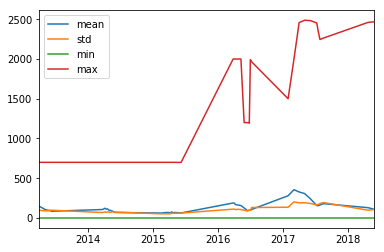

In [8]:
df.plot()

In [ ]:
# Histogram Function

def histogram_df(depth_array, binx, mask_array = None, mask_value = None):
    
    ''' histogram dataframe'''
    if mask_array is None:
        return np.nanmean(depth_array[depth_array>0])
    else: 
        hist = np.histogram(depth_array[(mask_array == mask_value) & (depth_array > 0)], binx)
        return hist
    


In [ ]:
#call histogram function

df_h = pd.DataFrame()
binx = np.arange(0,1500,30)

for f in sorted(flist):
    fDate = flight_date(f)
    d = io.imread(f)
    hist = histogram_df(d, binx, mask_array = mask, mask_value=np.max(mask))
    df_h['histogram']=hist
# df=df.transpose()
# df.columns='histogram'
df_h

In [20]:
df = pd.DataFrame()
df['lidar flight'] = [ 2013 , 2014 , 2015] 
df['mean'] = ['5','5','5']
df['std'] = ['5','5','5']
df['min'] = ['5','5','5']
df['max'] = ['5','5','5']
df['#pixels'] = ['5','5','5']
df.set_index('lidar flight', inplace=True)
df

,mean,std,min,max,#pixels
lidar flight,,,,,
2013,5,5,5,5,5
2014,5,5,5,5,5
2015,5,5,5,5,5


In [ ]:
print(depth_tum)

In [1]:
for f in sorted(flist):
    d = io.imread(f) #is numpy array 
    print(f, d.shape)

NameError: name 'flist' is not defined

In [ ]:
# print(flist[:2])
# d = io.imread(flist[40]) #is numpy array
# print('type:', type(d), '\nshape:', d.shape)
# print('meanfooo', np.nanmean(d[d>0]))
##no indexing
# plt.imshow(d)
# plt.colorbar()
# plt.show()

##copies, indexs>0, and plots
# idx = d>0
# d_tmp = d.copy()
# d_tmp[~idx]=np.nan

# plt.imshow(d_tmp, cmap='jet')
# plt.colorbar()